In [32]:
suMin = float("inf")
suMax = -float("inf")
spMin = float("inf")
spMax = -float("inf")
MALWARE = 1
BENIGN = 0

In [33]:
def getData(uFd, pFd):
    global suMin
    global suMax
    global spMin
    global spMax
    print("working on file %s %s" % (uFd.name, pFd.name))
    x = []
    y = []
    while True:
        uL = uFd.readline()
        pL = pFd.readline()
        if not uL and pL: raise Exception("Different # lines")
        if uL and not pL: raise Exception("Different # lines")
        if not uL and not pL: break
            
        t1 = uL.split(",")[0]
        su = float(uL.split(",")[1])
        if su != float("inf") and su != -float("inf") and su < suMin: suMin = su
        if su != float("inf") and su != -float("inf") and su > suMax: suMax = su
            
        t2 = pL.split(",")[0]
        sp = float(pL.split(",")[1])
        if sp != float("inf") and sp != -float("inf") and sp < spMin: spMin = sp
        if sp != float("inf") and sp != -float("inf") and sp > spMax: spMax = su

            
        if t1 != t2: raise Exception("Inconsistent label, %s %s" % (pL, uL))
        
        x.append([su, sp]) #UA, PATH score
        if t1 == "m": y.append(MALWARE)
        elif t1 == "b": y.append(BENIGN)
        else: raise Exception("Invalid label, %s %s" % (pL, uL))

    return x, y

In [34]:
seqFolds = {}
for seqLen in [10, 20, 30, 40]:
    ua_data = '../hmm/UA_DATA/ua-5-fold/ua%d' % seqLen 
    path_data = '../hmm/PATH_DATA/path-5-fold/path%d' % seqLen
    folds = []
    for f in range(1,6):

        uTrain = open("%s/ua.train%d.txt" % (ua_data, f), "r")
        pTrain = open("%s/path.train%d.txt" % (path_data, f), "r")
        uTest = open("%s/ua.test%d.txt" % (ua_data, f), "r")
        pTest = open("%s/path.test%d.txt" % (path_data, f), "r")

        xTrain, yTrain = getData(uTrain, pTrain)
        xTest, yTest = getData(uTest, pTest)
        folds.append([xTrain, yTrain, xTest, yTest])

        print("fold %d: " % f)
        print("train: ", len(xTrain), len(yTrain))
        print("test: ", len(xTest), len(yTest))

    #replace INF
    suMax += 1
    suMin -= 1
    spMax += 1
    spMin -= 1
    for xTrain, yTrain, xTest, yTest in folds:
        for i in range(len(xTrain)):
            if xTrain[i][0] == float("inf"): xTrain[i][0] = suMax
            if xTrain[i][0] == -float("inf"): xTrain[i][0] = suMin
            if xTrain[i][1] == float("inf"): xTrain[i][1] = spMax
            if xTrain[i][1] == -float("inf"): xTrain[i][1] = spMin 
        for i in range(len(xTest)):
            if xTest[i][0] == float("inf"): xTest[i][0] = suMax
            if xTest[i][0] == -float("inf"): xTest[i][0] = suMin
            if xTest[i][1] == float("inf"): xTest[i][1] = spMax
            if xTest[i][1] == -float("inf"): xTest[i][1] = spMin 

    #normalized it to 0 to 1
    for xTrain, yTrain, xTest, yTest in folds:
        for i in range(len(xTrain)):
            xTrain[i][0] = (xTrain[i][0] - suMin) / (suMax - suMin)
            xTrain[i][1] = (xTrain[i][1] - spMin) / (spMax - spMin)
        for i in range(len(xTest)):
            xTest[i][0] = (xTest[i][0] - suMin) / (suMax - suMin)
            xTest[i][1] = (xTest[i][1] - spMin) / (spMax - spMin)

    seqFolds[seqLen] = folds
    
print("done")

working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.train1.txt ../hmm/PATH_DATA/path-5-fold/path10/path.train1.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.test1.txt ../hmm/PATH_DATA/path-5-fold/path10/path.test1.txt
fold 1: 
train:  1913 1913
test:  459 459
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.train2.txt ../hmm/PATH_DATA/path-5-fold/path10/path.train2.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.test2.txt ../hmm/PATH_DATA/path-5-fold/path10/path.test2.txt
fold 2: 
train:  1881 1881
test:  491 491
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.train3.txt ../hmm/PATH_DATA/path-5-fold/path10/path.train3.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.test3.txt ../hmm/PATH_DATA/path-5-fold/path10/path.test3.txt
fold 3: 
train:  1900 1900
test:  472 472
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.train4.txt ../hmm/PATH_DATA/path-5-fold/path10/path.train4.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua10/ua.test4.txt ../hmm/PATH_DATA/path-5-fold/path10/p

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


def getModel():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

seqYTest = {}
seqYScore = {}
seqColors = {}
for seqLen in [10, 20, 30, 40]:
    y_test = [] #gt
    y_score = [] #scores
    colors = []
    red = (1, 0, 0)
    blue = (0, 0, 1)
    folds = seqFolds[seqLen]
    for fold_num in range(5):
        xTrain, yTrain, xTest, yTest = folds[fold_num]
        xTrain = np.array(xTrain)
        xTest = np.array(xTest)
        yTrain = np.array(yTrain)
        yTest = np.array(yTest)

        #Neural Network
        model = getModel()
        model.fit(xTrain, yTrain, epochs=20, batch_size=32, validation_data=(xTest, yTest) , verbose=0)
        _yPred = model.predict(xTest)
        for i in range(_yPred.shape[0]):
            y_test.append(yTest[i])
            y_score.append(_yPred[i])
            if yTest[i] == MALWARE: colors.append(red)
            else: colors.append(blue)

    y_test = np.array(y_test)
    y_score = np.array(y_score)
    colors = np.array(colors)
    print(seqLen, ": ", y_test.shape, y_score.shape, colors.shape)
    seqYTest[seqLen] = y_test
    seqYScore[seqLen] = y_score
    seqColors[seqLen] = colors

10 :  (2372,) (2372, 1) (2372, 3)
20 :  (2272,) (2272, 1) (2272, 3)
30 :  (2172,) (2172, 1) (2172, 3)
40 :  (2072,) (2072, 1) (2072, 3)


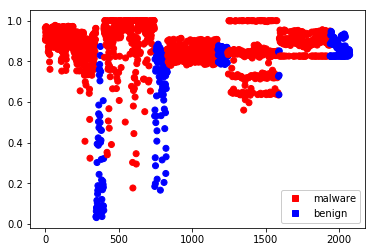

In [48]:
#scatter plot for scores
cStr = ['red', 'blue']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", cStr[i]) for i in range(2)]
labels = ['malware', 'benign']
plt.legend(handles, labels, loc="best", framealpha=1)

seqLen = 40
y_test = seqYTest[seqLen]
y_score = seqYScore[seqLen]
colors = seqColors[seqLen]
plt.scatter(np.arange(y_score.shape[0]), y_score, c=colors)

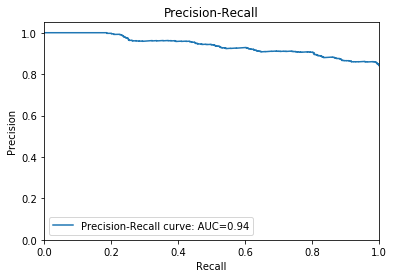

In [42]:
from sklearn_evaluation import plot

plot.precision_recall(y_test, y_score)

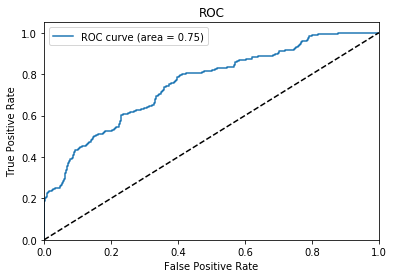

In [43]:
plot.roc(y_test, y_score)

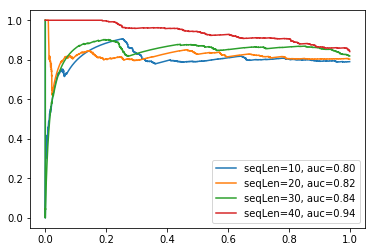

In [50]:
from sklearn import metrics

for seqLen in [10, 20, 30, 40]:
    y_true = seqYTest[seqLen]
    y_score = seqYScore[seqLen]
    
#     fpr, tpr, thresh = metrics.roc_curve(y_true, y_score)
#     auc = metrics.roc_auc_score(y_true, y_score)
#     plt.plot(fpr,tpr,label="seqLen=%d, auc=%s" % (seqLen, str(auc)))
    
    precision, recall, thresh = metrics.precision_recall_curve(y_true, y_score)
    apr = metrics.average_precision_score(y_true, y_score)
    plt.plot(recall,precision,label="seqLen=%d, auc=%.2f" % (seqLen, apr))

plt.legend(loc=0)
plt.show()